In [1]:
import numpy as np
from fireworks.particles import Particles
import fireworks.ic as fic
import fireworks.nbodylib.nunits as fnu
import fireworks.nbodylib.dynamics as fdyn
import fireworks.nbodylib.integrators as fint
import fireworks.nbodylib.timesteps as fts
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time as tm
import math

# Masses have to be in the same (any) unit
# R can have any unit provided that pc is expressed in the same unit
# Initial guess has to be in km and km/s

# Mass of the Sun, mass of the larger primary, mass of the smaller primary,
# labels of the primaries, mass of satellite, unit of masses, 
# distance between the primaries, unit of the distance, pc in that unit
MSun = 1.9891e30 #kg
M1 = MSun
M2 = 5.9724e24 #kg
m1_label = str('Sun')
m2_label = str('Earth')
Msat = 5000. #kg
m_unit = str('kg')
R = 1. #AU
l_unit = str('AU')
pc = 3.0857e18/1.4960e13 #AU

# Tolerance for iterations and integrations
tol = 1.e-14

# Initial guess for initial satellite state (as a phase space state) in rotating frame
guess = np.array([151300000.,0.,600000.,0.,-0.4,0.]) # Pos in km, vel in km/s

# Rescaling of units (M1+M2=1, distance=1, G=1)
Mtot = M1+M2
nu = fnu.Nbody_units(M=Mtot/MSun,L=R/pc) # Units are Mtot(MSun) for mass, R(pc) for length (time and velocity will be automatically set to have G=1)

# Defining mu (the rescaled mass of the smaller primary)
mu = nu.m_to_Nbody(M2/Mtot)

# Rescaling the initial phase space state guess
r0 = np.array([nu.pos_to_Nbody(guess[0]/nu.Lscale/3.0857e13),0.,nu.pos_to_Nbody(guess[2]/nu.Lscale/3.0857e13),0.,nu.vel_to_Nbody(guess[4]),0.])

# Initial Particles instance for satellite body (position and velocity of the satellite in synodic frame, rescaled mass of the smaller primary)
sat0 = Particles(position=r0[0:3],velocity=r0[3:6],mass=mu)

# Initial condition for the binary (with rescaled quantities, larger primary on the left, smaller primary on the right) in inertial frame
binary = fic.ic_two_body(1.-mu,mu,1.,e=0.)

# Shift COM position in 0 (v_COM is already 0)
binary.pos = binary.pos-binary.com_pos()

# Printing the input variables
print()
print(f"{'The mass of the larger primary ('+m1_label+') is:':<52}{M1:>11}{m_unit:>3}")
print(f"{'The mass of the smaller primary ('+m2_label+') is:':<52}{M2:>11}{m_unit:>3}")
print(f"{'The mass of the satellite is:':<52}{Msat:>11}{m_unit:>3}")
print(f"{'The distance between the primaries is:':<52}{R:>11}{l_unit:>3}")
print(f"{'The initial guess for the satellite position is:':<52}{guess[0]:>11}{' '}{'km':<5}{guess[1]:>11}{' '}{'km':<5}{guess[2]:>11}{' '}{'km':<5}")
print(f"{'The initial guess for the satellite velocity is:':<52}{guess[3]:>11}{' '}{'km/s':<5}{guess[4]:>11}{' '}{'km/s':<5}{guess[5]:>11}{' '}{'km/s':<5}")
print()
print('The initial guess for the satellite phase space state in Nbody units in rotating frame is:')
print(f"{'x':<25}{'y':<10}{'z':<25}{'vx':<10}{'vy':<25}{'vz':<10}")
print(f"{r0[0]:<25}{r0[1]:<10}{r0[2]:<25}{r0[3]:<10}{r0[4]:<25}{r0[5]:<10}")
print()

# Setting the estimator (CR3BP for satellite in effective potential produced by the binary in synodic frame)
estimator = fdyn.acceleration_cr3bp

# Setting the integrator (RK4)
integrator = fint.integrator_rk4

# Setting the time-step strategy
tstrat = fts.adaptive_timestep_combined

# Boundaries for timestep
tmin = 1.e-9
tmax = 1.e-3

# Counter for iterations
counter = 0

# Estimator of Phi' (Phi'=A*Phi)
def estimator_phi(Phi,X):
    R1 = np.sqrt((X[0]+mu)**2.+X[1]**2.+X[2]**2.)
    R2 = np.sqrt((X[0]-1.+mu)**2.+X[1]**2.+X[2]**2.)
    Uxx = 1.-(1.-mu)/R1**3.-mu/R2**3.+3.*(1.-mu)*(X[0]+mu)**2./R1**5.+3.*mu*(X[0]-1.+mu)**2./R2**5.
    Uyy = 1.-(1.-mu)/R1**3.-mu/R2**3.+3.*((1.-mu)/R1**5.+mu/R2**5.)*X[1]**2.
    Uzz = -(1.-mu)/R1**3.-mu/R2**3.+3*((1.-mu)/R1**5.+mu/R2**5.)*X[2]**2.
    Uxy = 3.*((1.-mu)*(X[0]+mu)/R1**5.+mu*(X[0]-1.+mu)/R2**5.)*X[1]
    Uxz = 3.*((1.-mu)*(X[0]+mu)/R1**5.+mu*(X[0]-1.+mu)/R2**5.)*X[2]
    Uyz = 3.*((1.-mu)/R1**5.+mu/R2**5.)*X[1]*X[2]
    A = np.array([[ 0., 0., 0., 1., 0., 0.],
                  [ 0., 0., 0., 0., 1., 0.],
                  [ 0., 0., 0., 0., 0., 1.],
                  [Uxx,Uxy,Uxz, 0., 2., 0.],
                  [Uxy,Uyy,Uyz,-2., 0., 0.],
                  [Uxz,Uyz,Uzz, 0., 0., 0.]])
    return np.dot(A,Phi)

# Integrator for Phi matrix
def rk4phi(phi,part,h):
    k1 = h*estimator_phi(phi,part.pos[0])
    k2 = h*estimator_phi(phi+0.5*k1,integrator(part.copy(),0.5*h,estimator)[0].pos[0])
    k3 = h*estimator_phi(phi+0.5*k2,integrator(part.copy(),0.5*h,estimator)[0].pos[0])
    k4 = h*estimator_phi(phi+k3,integrator(part.copy(),h,estimator)[0].pos[0])
    phinew = phi+1./6.*(k1+2*k2+2*k3+k4)
    return phinew

# Estimator of Jacobi constant
def jacobi(part):
    x = part.pos[0]
    v = part.vel[0]
    mu = part.mass[0]
    r1 = np.sqrt((x[0]+mu)**2.+x[1]**2.+x[2]**2.)
    r2 = np.sqrt((x[0]-1.+mu)**2.+x[1]**2.+x[2]**2.)
    return 2.*(1.-mu)/r1+2.*mu/r2+x[0]**2.+x[1]**2.-v[0]**2.-v[1]**2.-v[2]**2.



The mass of the larger primary (Sun) is:             1.9891e+30 kg
The mass of the smaller primary (Earth) is:          5.9724e+24 kg
The mass of the satellite is:                            5000.0 kg
The distance between the primaries is:                      1.0 AU
The initial guess for the satellite position is:    151300000.0 km           0.0 km      600000.0 km   
The initial guess for the satellite velocity is:            0.0 km/s        -0.4 km/s         0.0 km/s 

The initial guess for the satellite phase space state in Nbody units in rotating frame is:
x                        y         z                        vx        vy                       vz        
1.0113636363636362       0.0       0.004010695187165775     0.0       -0.013428115749385005    0.0       



In [2]:
# Starting the integration
print('Integrating the orbit and evaluating corrections...')
print('(The task may require a couple of minutes to complete)')
print()

# Loop for iterations to reach a mirror configuration for the final phase space state
t1 = tm.perf_counter()
while(True):
    
    # Counting the number of iterations performed
    counter +=1

    # Setting the initial state
    sat = sat0.copy()

    # Initial time
    t = 0.
    
    # Time list
    time = [t]

    # Lists of positions and velocities of the satellite body
    x = [sat.pos[0,0]]
    y = [sat.pos[0,1]]
    z = [sat.pos[0,2]]
    vx = [sat.vel[0,0]]
    vy = [sat.vel[0,1]]
    vz = [sat.vel[0,2]]

    # Setting initial acceleration
    sat.set_acc(estimator(sat)[0])

    # Initial condition for the differential state transition matrix (Phi=I)
    phi = np.identity(6)

    # Integration until y=0
    while(True):

        # Copying particles instance before time-step (to pass it to Phi integrator)
        sat_old = sat.copy()

        # Evaluating adaptive time-step
        tstep = tstrat(sat,tmin,tmax)
        
        # Reducing the time-step when coming back toward the xz plane, very close to y=0
        if(abs(y[-1])<0.00001 and vy[-1]*vy[0]<0): tstep /= 10.
        if(abs(y[-1])<0.000001 and vy[-1]*vy[0]<0): tstep /= 10.
        if(abs(y[-1])<0.0000001 and vy[-1]*vy[0]<0): tstep /= 10.
        if(abs(y[-1])<0.00000001 and vy[-1]*vy[0]<0): tstep /= 10.
        if(abs(y[-1])<0.000000001 and vy[-1]*vy[0]<0): tstep /= 10.
        if(abs(y[-1])<0.0000000001 and vy[-1]*vy[0]<0): tstep /= 10.
        if(abs(y[-1])<0.00000000001 and vy[-1]*vy[0]<0): tstep /= 10.
        if(abs(y[-1])<0.000000000001 and vy[-1]*vy[0]<0): tstep /= 10.
        if(abs(y[-1])<0.0000000000001 and vy[-1]*vy[0]<0): tstep /= 10.
        if(abs(y[-1])<0.00000000000001 and vy[-1]*vy[0]<0): tstep /= 10.

        # Evaluating time-step for Phi integration
        tstep_phi = 1.e-5 * np.sqrt(np.sum(estimator_phi(phi,sat_old.pos[0])**2.))/np.sqrt(np.sum(phi**2.))

        # Choosing the minimum time-step
        tstep = min(tstep,tstep_phi)
        
        # Integrating particles instance over a time-step
        sat,teffective,_,_,_ = integrator(sat,tstep,estimator)

        # Integration of Phi matrix over a time-step
        phi = rk4phi(phi,sat_old,teffective)
        
        # Updating time and saving it in time list
        t += teffective        
        time.append(t)
        
        # Saving satellite positions and velocities in lists
        x.append(sat.pos[0,0])
        y.append(sat.pos[0,1])
        z.append(sat.pos[0,2])
        vx.append(sat.vel[0,0])
        vy.append(sat.vel[0,1])
        vz.append(sat.vel[0,2])

        # Stopping integration at xz plane (y=0) when satellite comes back to the plane (vy*vy0<0)
        if(abs(y[-1])<tol and vy[-1]*vy[0]<0.): break

    # Printing current iteration status
    print(f"{'Iteration number:':<20}{counter:<6}{'Precision reached:':<20}{'1e'+str(math.floor(math.log(max(abs(vx[-1]),abs(vz[-1])),10))):>5}{' (threshold '+str(tol)+')'}")
    
    # Checking if mirror configuration is reached (vx=vz=0)
    if(abs(vx[-1])<tol and abs(vz[-1])<tol): break

    # Producing the final phase space state derivative (r_dot=(vx,vy,vz,ax,ay,az)) as column vector
    r_dot = np.array([sat.vel[0,0],sat.vel[0,1],sat.vel[0,2],sat.acc[0,0],sat.acc[0,1],sat.acc[0,2]])[:,None]

    # Computing coefficients for correction matrix
    B = phi-r_dot*phi[1,:]/r_dot[1,0]

    '''
    # Evaluating corrections fixing x0 (i.e., dx0=0) and applying the correction to the initial state
    dz0 = (r_dot[2,0]/B[5,4]-r_dot[0,0]/B[3,4])/(B[3,2]/B[3,4]-B[5,2]/B[5,4])
    dvy0 = -(B[5,2]*dz0+r_dot[2,0])/B[5,4]
    sat0.pos[0,2] += dz0
    sat0.vel[0,1] += dvy0
    '''

    # Evaluating corrections fixing z0 (i.e., dz0=0) and applying the correction to the initial state
    dvy0 = (r_dot[2,0]/B[5,0]-r_dot[0,0]/B[3,0])/(B[3,4]/B[3,0]-B[5,4]/B[5,0])
    dx0 = -(B[5,4]*dvy0+r_dot[2,0])/B[5,0]
    sat0.pos[0,0] += dx0
    sat0.vel[0,1] += dvy0

    '''
    # Evaluating corrections fixing vy0 (i.e., dvy0=0) and applying the correction to the initial state
    dz0 = (r_dot[2,0]/B[5,0]-r_dot[0,0]/B[3,0])/(B[3,2]/B[3,0]-B[5,2]/B[5,0])
    dx0 = -(B[5,2]*dz0+r_dot[2,0])/B[5,0]
    sat0.pos[0,0] += dx0
    sat0.pos[0,2] += dz0
    '''

    '''
    # Evaluating corrections fixing the period of the orbit and applying correction to the initial state
    # NOTE: apply this corretion ONLY IF the initial guess is reasonably close to a periodic orbit
    Chi = np.array([sat0.pos[0,0],sat0.pos[0,2],sat0.vel[0,1]])[:,None]
    F = np.array([y[-1],,vx[-1],vz[-1]])[:,None]
    J = np.array([[phi[1,0],phi[1,2],phi[1,4]],
                  [phi[3,0],phi[3,2],phi[3,4]],
                  [phi[5,0],phi[5,2],phi[5,4]]])
    Jinv = np.linalg.inv(J)
    Chinew = Chi-np.dot(Jinv,F)
    sat0.pos[0,0] = Chinew[0,0]
    sat0.pos[0,2] = Chinew[1,0]
    sat0.vel[0,1] = Chinew[2,0]
    '''

# Saving computational time
t2 = tm.perf_counter()
dt = t2-t1


Integrating the orbit and evaluating corrections...
(The task may require a couple of minutes to complete)

Iteration number:   1     Precision reached:   1e-3 (threshold 1e-14)
Iteration number:   2     Precision reached:   1e-4 (threshold 1e-14)
Iteration number:   3     Precision reached:   1e-6 (threshold 1e-14)
Iteration number:   4     Precision reached:   1e-9 (threshold 1e-14)
Iteration number:   5     Precision reached:  1e-13 (threshold 1e-14)
Iteration number:   6     Precision reached:  1e-14 (threshold 1e-14)
Iteration number:   7     Precision reached:  1e-14 (threshold 1e-14)
Iteration number:   8     Precision reached:  1e-15 (threshold 1e-14)


In [3]:
# Printing the number of iterations and the computational time
print()
print('Convergence reached')
print()
print(f"{'Number of iterations executed to reach a periodic orbit (up to '+str(tol)+' tolerance):':<80}{counter:>12}")
print(f"{'Time elapsed to reach a periodic orbit (up to '+str(tol)+' tolerance):':<80}{round(dt,2):>12}{' s'}")
print()

# Printing the corrected initial state
print('The corrected initial state of the satellite in Nbody units is:')
print(f"{'x':<25}{'y':<25}{'z':<25}")
print(f"{sat0.pos[0,0]:<25}{sat0.pos[0,1]:<25}{sat0.pos[0,2]:<25}")
print(f"{'vx':<25}{'vy':<25}{'vz':<25}")
print(f"{sat0.vel[0,0]:<25}{sat0.vel[0,1]:<25}{sat0.vel[0,2]:<25}")
print()
phys = np.array([nu.pos_to_physical(sat0.pos[0,0])*nu.Lscale*3.0857e13,0.,nu.pos_to_physical(sat0.pos[0,2])*nu.Lscale*3.0857e13,0.,nu.vel_to_kms(sat0.vel[0,1]),0.])
print('The corrected initial state of the satellite in physical units is:')
print(f"{'x (km)':<25}{'y (km)':<25}{'z (km)':<25}")
print(f"{phys[0]:<25}{phys[1]:<25}{phys[2]:<25}")
print(f"{'vx (km/s)':<25}{'vy (km/s)':<25}{'vz (km/s)':<25}")
print(f"{phys[3]:<25}{phys[4]:<25}{phys[5]:<25}")
print()

# Evaluating the period of the orbit of the satellite
period = 2.*t

# Printing the period
print(f"{'The period of the satellite orbit in Nbody units is:':<60}{period}")
period_sec = nu.t_to_physical(period)/3.1709791983765E-14
period_month = period_sec*3.80517e-7
print(f"{'The period of the satellite orbit in physical units is:':<60}{period_sec}{' s':<4}{'('}{period_month}{' months)'}")
print()



Convergence reached

Number of iterations executed to reach a periodic orbit (up to 1e-14 tolerance):           8
Time elapsed to reach a periodic orbit (up to 1e-14 tolerance):                       215.11 s

The corrected initial state of the satellite in Nbody units is:
x                        y                        z                        
1.0110161314097528       0.0                      0.004010695187165775     
vx                       vy                       vz                       
0.0                      -0.010862051868686872    0.0                      

The corrected initial state of the satellite in physical units is:
x (km)                   y (km)                   z (km)                   
151248013.258899         0.0                      600000.0                 
vx (km/s)                vy (km/s)                vz (km/s)                
0.0                      -0.32356146078601816     0.0                      

The period of the satellite orbit in Nbody units

In [4]:
# Evaluating L2 point
tolerance = 1.e-10
fL2 = lambda xi: xi**5.+(4.*mu-2.)*xi**4.+(6.*mu**2.-6.*mu+1.)*xi**3.+(4.*mu**3.-6.*mu**2.+2.*mu-1.)*xi**2.+(mu**4.-2.*mu**3.+mu**2.-4.*mu+2.)*xi+(-3.*mu**2.+3.*mu-1.)
der2 = lambda xi: 5.*xi**4.+(4.*mu-2.)*4.*xi**3.+(6.*mu**2.-6.*mu+1.)*3.*xi**2.+(4.*mu**3.-6.*mu**2.+2.*mu-1.)*2*xi+(mu**4.-2.*mu**3.+mu**2.-4.*mu+2.)
xL2 = 1.
while(True):
    xL2old = xL2
    xL2 = xL2-fL2(xL2)/der2(xL2)
    if(abs(xL2-xL2old)<tolerance): break


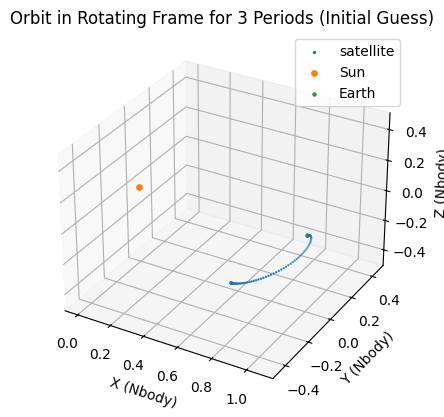

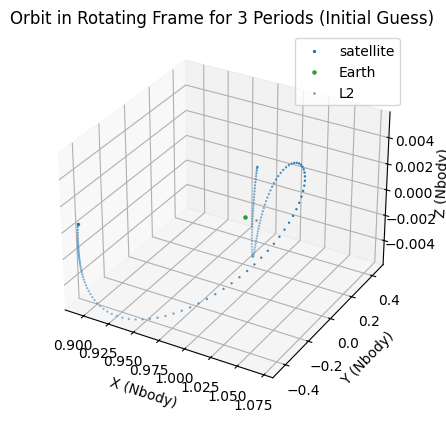

In [5]:
# Plot of 3 periods (non-corrected initial guess)
satwrong = Particles(position=r0[0:3],velocity=r0[3:6],mass=mu)
t = 0.
x = [satwrong.pos[0,0]]
y = [satwrong.pos[0,1]]
z = [satwrong.pos[0,2]]
satwrong.set_acc(estimator(satwrong)[0])
while(t<3.*period):
    tstep = tstrat(satwrong,tmin,tmax)
    satwrong,teffective,_,_,_ = integrator(satwrong,tstep,estimator)
    t += teffective
    x.append(satwrong.pos[0,0])
    y.append(satwrong.pos[0,1])
    z.append(satwrong.pos[0,2])
fig0 = plt.figure()
ax0 = fig0.add_subplot(111,projection='3d')
ax0.scatter(x[::100],y[::100],z[::100],s=0.5,c='C0')
ax0.scatter(x[::100][-1],y[::100][-1],z[::100][-1],s=2,c='C0',label='satellite')
ax0.scatter(-mu,0.,0.,s=15,c='C1',label=m1_label) # M1
ax0.scatter(1.-mu,0.,0.,s=5,c='C2',label=m2_label) # M2
ax0.set_xlabel('X (Nbody)')
ax0.set_ylabel('Y (Nbody)')
ax0.set_zlabel('Z (Nbody)')
ax0.set_ylim(-max([abs(ele) for ele in y]),max([abs(ele) for ele in y]))
ax0.set_zlim(-max([abs(ele) for ele in y]),max([abs(ele) for ele in y]))
ax0.legend(loc='upper right')
plt.title('Orbit in Rotating Frame for 3 Periods (Initial Guess)')
plt.grid(True)
plt.savefig('incorrect.pdf')
# Zoomed-in
fig01 = plt.figure()
ax01 = fig01.add_subplot(111,projection='3d')
ax01.scatter(x[::100],y[::100],z[::100],s=0.5,c='C0')
ax01.scatter(x[::100][-1],y[::100][-1],z[::100][-1],s=2,c='C0',label='satellite')
ax01.scatter(1.-mu,0.,0.,s=5,c='C2',label=m2_label) # M2
ax01.scatter(xL2,0.,0.,s=0.5,c='C7',label='L2') # L2
ax01.set_xlabel('X (Nbody)')
ax01.set_ylabel('Y (Nbody)')
ax01.set_zlabel('Z (Nbody)')
ax01.set_ylim(-max([abs(ele) for ele in y]),max([abs(ele) for ele in y]))
ax01.set_zlim(-max([abs(ele) for ele in z]),max([abs(ele) for ele in z]))
ax01.legend(loc='upper right')
plt.title('Orbit in Rotating Frame for 3 Periods (Initial Guess)')
plt.grid(True)
plt.savefig('incorrect_zoom.pdf')


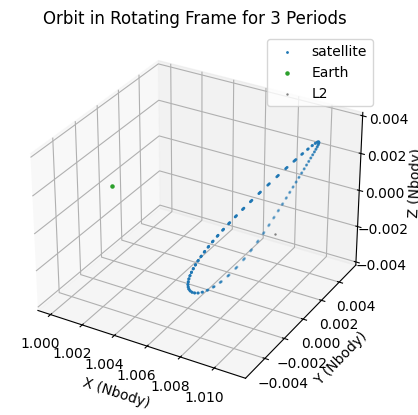

In [6]:
# Plot of 3 periods (correct)
sat3p = sat0.copy()
t = 0.
x = [sat3p.pos[0,0]]
y = [sat3p.pos[0,1]]
z = [sat3p.pos[0,2]]
sat3p.set_acc(estimator(sat3p)[0])
while(t<3.*period):
    tstep = tstrat(sat3p,tmin,tmax)
    sat3p,teffective,_,_,_ = integrator(sat3p,tstep,estimator)
    t += teffective
    x.append(sat3p.pos[0,0])
    y.append(sat3p.pos[0,1])
    z.append(sat3p.pos[0,2])
fig1 = plt.figure()
ax1 = fig1.add_subplot(111,projection='3d')
ax1.scatter(x[::100],y[::100],z[::100],s=1,c='C0',label='satellite')
ax1.scatter(1.-mu,0.,0.,s=5,c='C2',label=m2_label) # M2
ax1.scatter(xL2,0.,0.,s=0.5,c='C7',label='L2') # L2
ax1.set_xlabel('X (Nbody)')
ax1.set_ylabel('Y (Nbody)')
ax1.set_zlabel('Z (Nbody)')
ax1.set_ylim(-max([abs(ele) for ele in y]),max([abs(ele) for ele in y]))
ax1.set_zlim(-max([abs(ele) for ele in z]),max([abs(ele) for ele in z]))
ax1.legend(loc='upper right')
plt.title('Orbit in Rotating Frame for 3 Periods')
plt.grid(True)
plt.savefig('3periods.pdf')


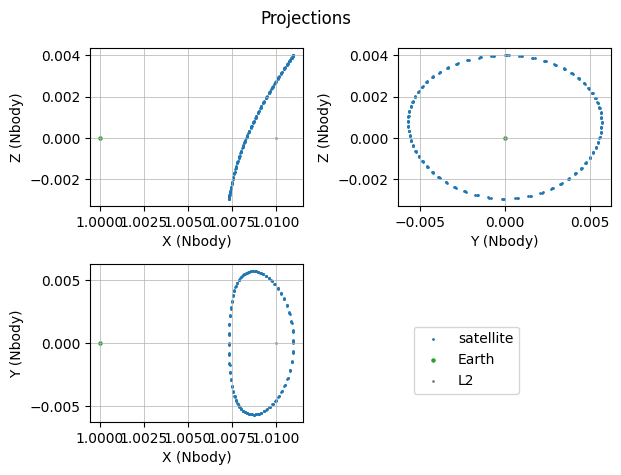

In [7]:
# Projections of the periodic orbit
fig11 = plt.figure()
# XZ
ax1xz = fig11.add_subplot(221)
ax1xz.scatter(x[::100],z[::100],s=1,c='C0')
ax1xz.scatter(1.-mu,0.,s=5,c='C2') # M2
ax1xz.scatter(xL2,0.,s=1,c='C7') # L2
ax1xz.set_xlabel('X (Nbody)')
ax1xz.set_ylabel('Z (Nbody)')
plt.grid(True,lw=0.5)
# YZ
ax1yz = fig11.add_subplot(222)
ax1yz.scatter(y[::100],z[::100],s=1,c='C0')
ax1yz.scatter(0.,0.,s=5,c='C2') # M2
ax1yz.scatter(0.,0.,s=1,c='C7') # L2
ax1yz.set_xlabel('Y (Nbody)')
ax1yz.set_ylabel('Z (Nbody)')
plt.grid(True,lw=0.5)
# XY
ax1xy = fig11.add_subplot(223)
ax1xy.scatter(x[::100],y[::100],s=1,c='C0')
ax1xy.scatter(1.-mu,0.,s=5,c='C2') # M2
ax1xy.scatter(xL2,0.,s=1,c='C7') # L2
ax1xy.set_xlabel('X (Nbody)')
ax1xy.set_ylabel('Y (Nbody)')
plt.grid(True,lw=0.5)
fig11.suptitle('Projections')
fig11.legend(['satellite',m2_label,'L2'],loc='center',bbox_to_anchor=(0.75,0.25))
fig11.tight_layout()
plt.savefig('projections.pdf')


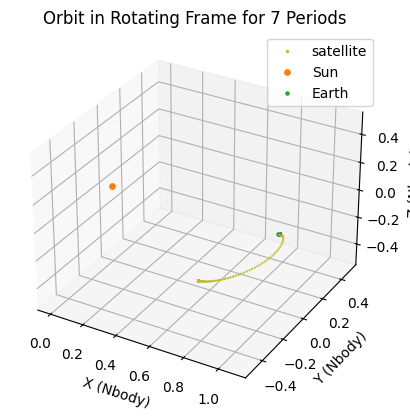

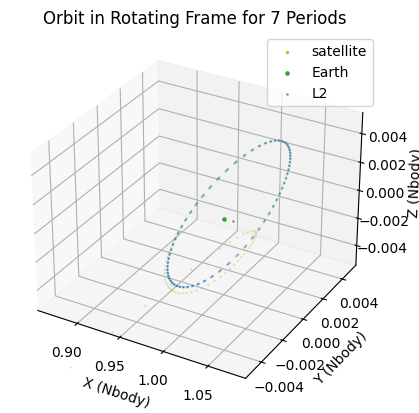

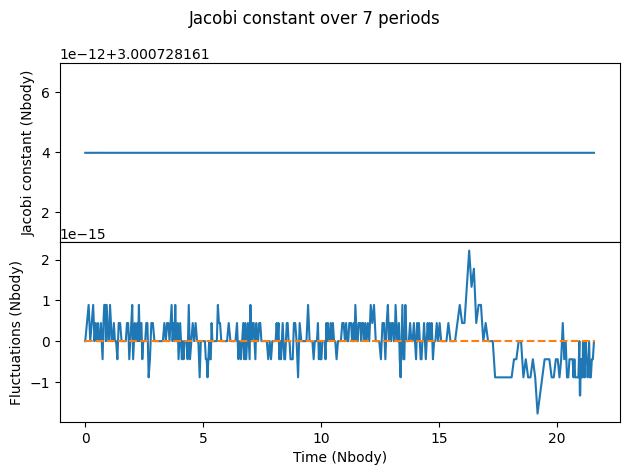

In [8]:
# PLot of 7 periods (with a color change at 3.5 periods to show orbital drift)
sat7p = sat0.copy()
t = 0.
time = [t]
x = [sat7p.pos[0,0]]
y = [sat7p.pos[0,1]]
z = [sat7p.pos[0,2]]
sat7p.set_acc(estimator(sat7p)[0])
jac = [jacobi(sat7p)]
color = ['C0']
while(t<7.*period):
    tstep = tstrat(sat7p,tmin,tmax)
    sat7p,teffective,_,_,_ = integrator(sat7p,tstep,estimator)
    t += teffective
    time.append(t)
    x.append(sat7p.pos[0,0])
    y.append(sat7p.pos[0,1])
    z.append(sat7p.pos[0,2])
    jac.append(jacobi(sat7p))
    if(t<=3.5*period): color.append('C0')
    else: color.append('C8')
fig2 = plt.figure()
ax2 = fig2.add_subplot(111,projection='3d')
ax2.scatter(x[::100],y[::100],z[::100],s=0.5,c=color[::100])
ax2.scatter(x[::100][-1],y[::100][-1],z[::100][-1],s=2,c=color[::100][-1],label='satellite')
ax2.scatter(-mu,0.,0.,s=15,c='C1',label=m1_label) # M1
ax2.scatter(1.-mu,0.,0.,s=5,c='C2',label=m2_label) # M2
ax2.set_xlabel('X (Nbody)')
ax2.set_ylabel('Y (Nbody)')
ax2.set_zlabel('Z (Nbody)')
ax2.set_ylim(-max([abs(ele) for ele in y]),max([abs(ele) for ele in y]))
ax2.set_zlim(-max([abs(ele) for ele in y]),max([abs(ele) for ele in y]))
ax2.legend(loc='upper right')
plt.title('Orbit in Rotating Frame for 7 Periods')
plt.grid(True)
plt.savefig('7periods.pdf')
# Zoomed-in
fig21 = plt.figure()
ax21 = fig21.add_subplot(111,projection='3d')
ax21.scatter(x[::100],y[::100],z[::100],s=0.5,c=color[::100])
ax21.scatter(x[::100][-1],y[::100][-1],z[::100][-1],s=2,c=color[::100][-1],label='satellite')
ax21.scatter(1.-mu,0.,0.,s=5,c='C2',label=m2_label) # M2
ax21.scatter(xL2,0.,0.,s=0.5,c='C7',label='L2') # L2
ax21.set_xlabel('X (Nbody)')
ax21.set_ylabel('Y (Nbody)')
ax21.set_zlabel('Z (Nbody)')
ax21.set_ylim(-max([abs(ele) for ele in z]),max([abs(ele) for ele in z]))
ax21.set_zlim(-max([abs(ele) for ele in z]),max([abs(ele) for ele in z]))
ax21.legend(loc='upper right')
plt.title('Orbit in Rotating Frame for 7 Periods')
plt.grid(True)
plt.savefig('7periods_zoom.pdf')

# Plot of Jacobi constant (over 7 periods)
fig3 = plt.figure()
gs3 = fig3.add_gridspec(2,hspace=0)
[ax30,ax31] = gs3.subplots(sharex=True)
ax30.plot(time[::100],jac[::100],c='C0')
ax30.set_ylabel('Jacobi constant (Nbody)')
ax31.plot(time[::100],jac[::100]-jac[0],c='C0')
ax31.hlines(0.,time[0],time[-1],ls='--',color='C1')
ax31.set_xlabel('Time (Nbody)')
ax31.set_ylabel('Fluctuations (Nbody)')
fig3.suptitle('Jacobi constant over 7 periods')
fig3.tight_layout()
plt.savefig('jacobi.pdf')


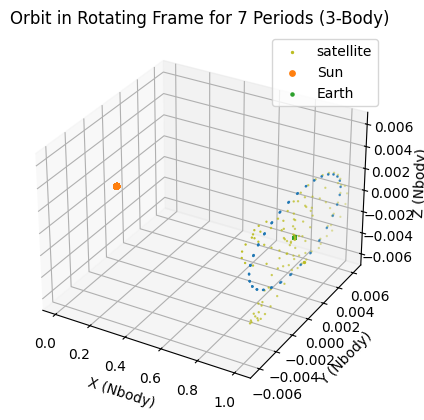

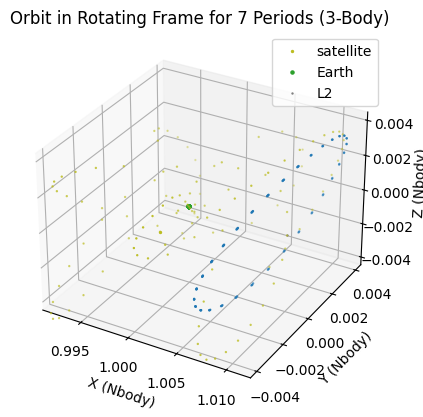

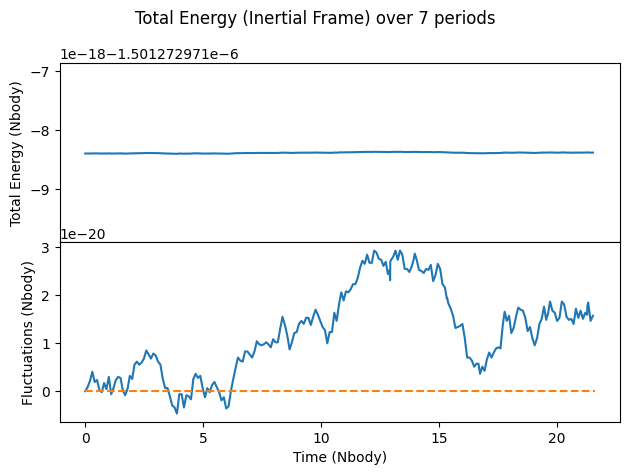

In [9]:
# Setting the estimator to direct acceleration (for 3-body integration)
estimator = fdyn.acceleration_direct_vectorised

# Rescaling Msat
msat = nu.m_to_Nbody(Msat/Mtot)

# Creating an inertial 3-body Particles instance (larger primary, smaller primary, satellite)
# Note that sat0.vel is the satellite velocity in the synodic frame,
# so it has to be corrected to obtain the inertial velocity:
# v_inertial = v_rot + (omega x r), where omega is (0,0,1) in rescaled units
threebody = Particles(position=[binary.pos[0],binary.pos[1],sat0.pos[0]],
                      velocity=[binary.vel[0],binary.vel[1],sat0.vel[0]+np.cross([0.,0.,1.],sat0.pos[0])],
                      mass=[binary.mass[0],binary.mass[1],msat])

# Initialising time and saving initial values
t = 0.
time = [t]
x1 = [threebody.pos[0,0]]
y1 = [threebody.pos[0,1]]
z1 = [threebody.pos[0,2]]
x2 = [threebody.pos[1,0]]
y2 = [threebody.pos[1,1]]
z2 = [threebody.pos[1,2]]
xsat = [threebody.pos[2,0]]
ysat = [threebody.pos[2,1]]
zsat = [threebody.pos[2,2]]
E = [threebody.Etot()[0]]

# Setting initial color
color = ['C0']

# Setting initial acceleration
threebody.set_acc(estimator(threebody)[0])

# Integration for 7 periods
while(t<7.*period):
    tstep = tstrat(threebody,tmin,tmax)
    threebody,teffective,_,_,_ = integrator(threebody,tstep,estimator)
    t += teffective
    
    # Rotation matrix for rotation from inertial frame to synodic one
    R = np.array([[np.cos(t),np.sin(t),0.],
                  [-np.sin(t),np.cos(t),0.],
                  [0.,0.,1.]])
    
    # Applying rotation
    pos_1 = np.dot(R,threebody.pos[0])
    pos_2 = np.dot(R,threebody.pos[1])
    pos_sat = np.dot(R,threebody.pos[2])

    # Saving time, positions in synodic frame and energy in inertial frame
    time.append(t)
    x1.append(pos_1[0])
    y1.append(pos_1[1])
    z1.append(pos_1[2])
    x2.append(pos_2[0])
    y2.append(pos_2[1])
    z2.append(pos_2[2])
    xsat.append(pos_sat[0])
    ysat.append(pos_sat[1])
    zsat.append(pos_sat[2])
    E.append(threebody.Etot()[0])

    # Setting color for plot (with a color change at 3.5 periods to show orbital drift)
    if(t<=3.5*period): color.append('C0')
    else: color.append('C8')

# Plot of the orbit with direct 3-body estimator
fig4 = plt.figure()
ax4 = fig4.add_subplot(111,projection='3d')
ax4.scatter(xsat[::100],ysat[::100],zsat[::100],s=0.5,c=color[::100])
ax4.scatter(xsat[::100][-1],ysat[::100][-1],zsat[::100][-1],s=2,c=color[::100][-1],label='satellite')
ax4.scatter(x1[::100],y1[::100],z1[::100],s=15,c='C1',label=m1_label) # M1
ax4.scatter(x2[::100],y2[::100],z2[::100],s=5,c='C2',label=m2_label) # M2
ax4.set_xlabel('X (Nbody)')
ax4.set_ylabel('Y (Nbody)')
ax4.set_zlabel('Z (Nbody)')
ax4.set_ylim(-max([abs(ele) for ele in ysat]),max([abs(ele) for ele in ysat]))
ax4.set_zlim(-max([abs(ele) for ele in ysat]),max([abs(ele) for ele in ysat]))
ax4.legend(loc='upper right')
plt.title('Orbit in Rotating Frame for 7 Periods (3-Body)')
plt.grid(True)
plt.savefig('7periods_3body.pdf')
# Zoomed-in
fig41 = plt.figure()
ax41 = fig41.add_subplot(111,projection='3d')
ax41.scatter(xsat[::100],ysat[::100],zsat[::100],s=0.5,c=color[::100])
ax41.scatter(xsat[::100][-1],ysat[::100][-1],zsat[::100][-1],s=2,c=color[::100][-1],label='satellite')
ax41.scatter(x2[::100],y2[::100],z2[::100],s=5,c='C2',label=m2_label) # M2
ax41.scatter(xL2,0.,0.,s=0.5,c='C7',label='L2') # L2
ax41.set_xlabel('X (Nbody)')
ax41.set_ylabel('Y (Nbody)')
ax41.set_zlabel('Z (Nbody)')
ax41.set_ylim(-max([abs(ele) for ele in zsat]),max([abs(ele) for ele in zsat]))
ax41.set_zlim(-max([abs(ele) for ele in zsat]),max([abs(ele) for ele in zsat]))
ax41.legend(loc='upper right')
plt.title('Orbit in Rotating Frame for 7 Periods (3-Body)')
plt.grid(True)
plt.savefig('7periods_3body_zoom.pdf')

# Plot of energy (in inertial frame) over 7 periods
fig5 = plt.figure()
gs5 = fig5.add_gridspec(2,hspace=0)
[ax50,ax51] = gs5.subplots(sharex=True)
ax50.plot(time[::100],E[::100],c='C0')
ax50.set_ylabel('Total Energy (Nbody)')
ax51.plot(time[::100],E[::100]-E[0],c='C0')
ax51.hlines(0.,time[0],time[-1],ls='--',color='C1')
ax51.set_xlabel('Time (Nbody)')
ax51.set_ylabel('Fluctuations (Nbody)')
fig5.suptitle('Total Energy (Inertial Frame) over 7 periods')
fig5.tight_layout()
plt.savefig('energy.pdf')

# Showing all plots
plt.show()